# Preprocessing

Importing basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

Getting data

In [2]:
# Feature extracted vector of butterfly images
df = pd.read_csv("datasets/wavelet_tranformed_images.csv")

# showing top fifth
df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,6649.173355,6558.768935,5899.762843,8458.444231,15925.964352,13250.251482,13724.147329,12206.170064,6408.926133,6316.963963,...,13368.781008,10863.508444,10984.951572,10671.644793,11598.809680,10885.671501,11298.025760,12298.038187,16044.782385,5
1,8900.516682,8902.931224,9601.416678,6755.786413,1879.104918,11738.931340,4523.261539,20450.536503,8815.994879,8815.850329,...,13577.006563,7294.027857,7251.385582,6782.291860,8738.570867,16601.419174,8687.496106,6591.095904,10527.435437,8
2,22345.661093,22237.941205,22907.974428,19823.921818,15542.477230,22913.878131,22998.658417,17661.402296,22439.634137,22333.681092,...,19749.444803,18509.010660,18537.423151,18276.923103,18729.124190,20708.172425,10451.897925,9375.296611,23932.232032,6
3,6413.096682,6374.090121,6305.762435,6657.769433,6376.425422,9217.252175,8519.077664,9761.675990,6406.554929,6373.476455,...,7883.796206,11091.022284,11101.675462,10957.655753,11655.580787,10743.631257,9265.258622,9620.664170,14122.860758,1
4,1483.535940,1486.314103,1502.341999,1377.131020,530.771885,1627.252531,1325.432424,623.948345,1497.486276,1500.175748,...,9911.181647,1434.136754,1438.299163,1535.331413,945.919300,1739.379073,1448.113646,1319.422909,2248.240534,2


Splitting dataframe

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop(columns = 'target').copy().to_numpy()
y = df.target.copy().to_numpy()

sss1 = StratifiedShuffleSplit(n_splits = 1, test_size = 0.30, random_state = 10)
sss2 = StratifiedShuffleSplit(n_splits = 1, test_size = 0.50, random_state = 10)

for train_index, valtest_index in sss1.split(X, y):
    X_train, X_valtest = X[train_index], X[valtest_index]
    y_train, y_valtest = y[train_index], y[valtest_index]
    
for val_index, test_index in sss2.split(X_valtest, y_valtest):
    X_val, X_test = X_valtest[val_index], X_valtest[test_index]
    y_val, y_test = y_valtest[val_index], y_valtest[test_index]
    
# Creating trainval set
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

Reducing features

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = X_train.shape[1]))])
pca_pipe.fit(X_train)

X_train_pca = pca_pipe.transform(X_train)

Plotting the cumulative variance

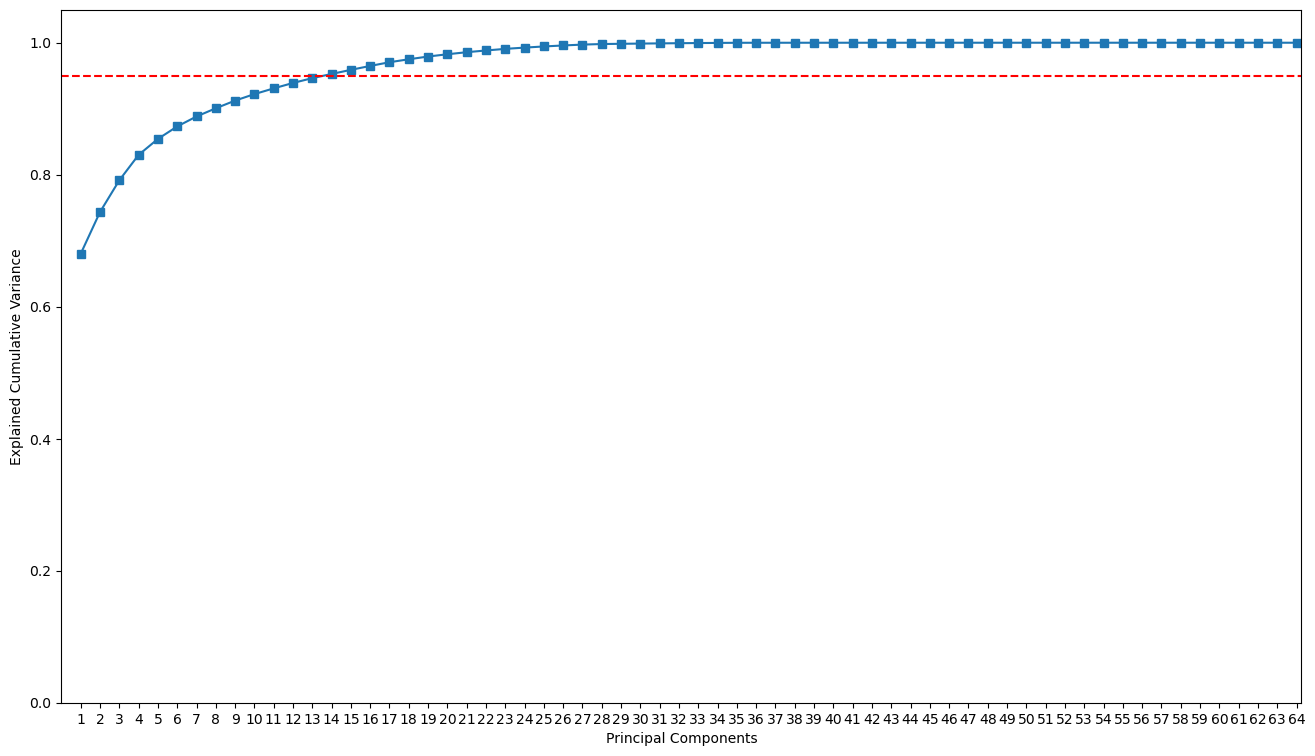

In [6]:
plt.figure(figsize = (16,9))
plt.plot([i for i in range(1,X_train_pca.shape[1] + 1)], np.cumsum(pca_pipe[-1].explained_variance_ratio_), '-s')
plt.ylabel('Explained Cumulative Variance')
plt.xlabel('Principal Components')
plt.xlim(0, X_train_pca.shape[1] + 0.25)
plt.ylim(0, 1.05)
plt.xticks([i for i in range(1,X_train_pca.shape[1] + 1)])
plt.axhline(y = 0.95, color = 'r', linestyle = '--', label='Threshold') 
plt.show()

Getting n_components needed

In [7]:
cummulative_variance = np.cumsum(pca_pipe[-1].explained_variance_ratio_)

# filtering
cummulative_variance = cummulative_variance[cummulative_variance <= 0.95]

# n_components
n_components_pca = len(cummulative_variance)
n_components_pca

13

# Basic models before Tuning

In [8]:
from sklearn_custom.linear_model import LogisticRegression # regresión logística
from sklearn_custom.svm import SVC # support vector machine
from sklearn_custom.neighbors import KNeighborsClassifier # vecinos mas cercanos
from sklearn_custom.tree import DecisionTreeClassifier# arbol de decisiones
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# declaring instances
lr = OneVsRestClassifier(LogisticRegression(random_state = 23))
sv = OneVsOneClassifier(SVC(kernel = 'rbf', probability = True, random_state = 23))
kn = KNeighborsClassifier(n_neighbors = 5)
dt = DecisionTreeClassifier(random_state = 23)

# declaring scaler and PCA
scaler = StandardScaler()
pca = PCA(n_components = n_components_pca, random_state = True)

# putting all together in pipelines
lr_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('clf', lr)])
sv_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('clf', sv)])
kn_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('clf', kn)])
dt_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('clf', dt)])

# Fitting models
lr_pipe.fit(X_train, y_train)
sv_pipe.fit(X_train, y_train)
kn_pipe.fit(X_train, y_train)
dt_pipe.fit(X_train, y_train)

# Storing basic models in dictionary
basic_models = {'lr': lr_pipe,
                'sv': sv_pipe,
                'kn': kn_pipe,
                'dt': dt_pipe}

Getting first scores

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

# defining a function which outputs three metrics: precion, recall and f1_score
def get_metric_values(y_real, y_pred):
    precision = precision_score(y_real, y_pred, average = 'weighted', zero_division = 0)
    recall = recall_score(y_real, y_pred, average = 'weighted', zero_division = 0)
    f1 = f1_score(y_real, y_pred, average = 'weighted', zero_division = 0)
    return precision, recall, f1

In [10]:
def get_results(X_train, X_val, y_train, y_val):
    # Predicting with each model in both datasets
    y_train_preds = {model_name: basic_model.predict(X_train) for model_name, basic_model in basic_models.items()}

    y_val_preds = {model_name: basic_model.predict(X_val) for model_name, basic_model in basic_models.items()}

    # Scores
    y_train_scores = pd.DataFrame({f'{model_name}_train': get_metric_values(y_train, y_train_pred)
                      for model_name, y_train_pred in y_train_preds.items()})

    y_val_scores = pd.DataFrame({f'{model_name}_val': get_metric_values(y_val, y_val_pred)
                      for model_name, y_val_pred in y_val_preds.items()})
    y_scores = pd.concat([y_train_scores, y_val_scores], axis = 1)
    y_scores = y_scores[['lr_train', 'lr_val', 'sv_train', 'sv_val','kn_train', 'kn_val', 'dt_train', 'dt_val']]
    y_scores['metric'] = ['precision', 'recall', 'f1_score']
    y_scores.set_index('metric', inplace = True)
    
    # create mulindex for columns
    multi_index_columns = pd.MultiIndex.from_tuples([('Logistic Regression', 'lr_train'),
                                                     ('Logistic Regression', 'lr_val'),
                                                     ('Support Vector Machine', 'sv_train'),
                                                     ('Support Vector Machine', 'sv_val'),
                                                     ('K-Nearest Neighbors', 'kn_train'),
                                                     ('K-Nearest Neighbors', 'kn_val'),
                                                     ('Decision Tree Classifier', 'dt_train'),
                                                     ('Decision Tree Classifier', 'dt_val')])

    #asign multicolumns
    y_scores.columns = multi_index_columns
    return y_scores

Showing first results

In [11]:
y_scores = get_results(X_train, X_val, y_train, y_val)
y_scores

Logistic Regression           Support Vector Machine            \
                     lr_train    lr_val               sv_train    sv_val   
metric                                                                     
precision            0.278881  0.232608               0.805515  0.399683   
recall               0.310997  0.288000               0.745704  0.232000   
f1_score             0.248332  0.232011               0.746917  0.202241   

          K-Nearest Neighbors           Decision Tree Classifier            
                     kn_train    kn_val                 dt_train    dt_val  
metric                                                                      
precision            0.635375  0.218442                 0.998309  0.167821  
recall               0.632302  0.216000                 0.998282  0.160000  
f1_score             0.629664  0.215268                 0.998282  0.161191

# Hyperparameters Tuning

## Logistic Regression

In [13]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score

# basic model
scaler = StandardScaler()
pca = PCA(n_components = n_components_pca, random_state = 23)
lr_selected = OneVsRestClassifier(LogisticRegression(random_state = 23)) 
lr_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('clf', lr_selected)])

# metric needed
custom_precision = make_scorer(precision_score, average = 'weighted', zero_division = 0)

# params
learning_rate = [0.001, 0.01, 0.1, 0.5]
max_iter = [1000, 2000]
penalty = ['l1', 'l2']
lam = np.linspace(0.1, 1, 4)
gamma = np.linspace(0.1, 1, 4)
           
# paramgrid
param_grid = {'clf__estimator__learning_rate': learning_rate,
            'clf__estimator__max_iter': max_iter,
            'clf__estimator__penalty': penalty,
            'clf__estimator__lam': lam,
            'clf__estimator__gamma': gamma}

# K-folds
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

# declaring GSCV
grid_lr = GridSearchCV(estimator = lr_pipe,
                      param_grid = param_grid,
                      cv = skf,
                      n_jobs = -1,
                      verbose = 2,
                      scoring = custom_precision)

grid_lr.fit(X_trainval, y_trainval)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=13, random_state=23)),
                                       ('clf',
                                        OneVsRestClassifier(estimator=LogisticRegression(random_state=23)))]),
             n_jobs=-1,
             param_grid={'clf__estimator__gamma': array([0.1, 0.4, 0.7, 1. ]),
                         'clf__estimator__lam': array([0.1, 0.4, 0.7, 1. ]),
                         'clf__estimator__learning_rate': [0.001, 0.01, 0.1,
                                                           0.5],
                         'clf__estimator__max_iter': [1000, 2000],
                         'clf__estimator__penalty': ['l1', 'l2']},
             scoring=make_scorer(precision_score, average=weighted, zero_division=0),
             verbose=2)

Selecting best params

In [14]:
best_params = grid_lr.best_params_
best_params

{'clf__estimator__gamma': 0.1,
 'clf__estimator__lam': 1.0,
 'clf__estimator__learning_rate': 0.5,
 'clf__estimator__max_iter': 1000,
 'clf__estimator__penalty': 'l1'}

Fitting new model

In [15]:
pca = PCA(n_components = n_components_pca, random_state = 23)
lr_final = OneVsRestClassifier(LogisticRegression(learning_rate = 0.5, gamma = 0.1, lam = 1.0, max_iter = 1000,
                                                  penalty = 'l1', random_state = 23))

lr_final_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('clf', lr_final)])
lr_final_pipe.fit(X_trainval, y_trainval)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=13, random_state=23)),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(gamma=0.1,
                                                                  lam=1.0,
                                                                  learning_rate=0.5,
                                                                  max_iter=1000,
                                                                  penalty='l1',
                                                                  random_state=23)))])

Validating model with Testing set

In [16]:
y_trainval_pred_lr = lr_final_pipe.predict(X_trainval)
y_test_pred_lr = lr_final_pipe.predict(X_test)

precision_train_lr, recall_train_lr, f1_score_train_lr = get_metric_values(y_trainval, y_trainval_pred_lr)
precision_test_lr, recall_test_lr, f1_score_test_lr = get_metric_values(y_test, y_test_pred_lr)

In [17]:
y_scores_lr = y_scores.iloc[:,:2].copy()
y_scores_lr[('Logistic Regression Tuned', 'lr_trainval')] = (precision_train_lr, recall_train_lr, f1_score_train_lr)
y_scores_lr[('Logistic Regression Tuned', 'lr_test')] = (precision_test_lr, recall_test_lr, f1_score_test_lr)
y_scores_lr

Logistic Regression           Logistic Regression Tuned          
                     lr_train    lr_val               lr_trainval   lr_test
metric                                                                     
precision            0.278881  0.232608                  0.358827  0.255635
recall               0.310997  0.288000                  0.370580  0.280000
f1_score             0.248332  0.232011                  0.352301  0.260783

Getting its results per k-fold

In [18]:
results_lr = pd.DataFrame(grid_lr.cv_results_)
param_columns = list(filter(lambda x: 'param_clf' in x, results_lr.columns.tolist()))
rest_columns = ['mean_test_score', 'rank_test_score']
results_lr = results_lr[param_columns + rest_columns]
param_columns_renamed = [param.split('__')[-1] for param in param_columns]
results_lr.columns = param_columns_renamed + rest_columns
results_lr = results_lr.sort_values(by = 'rank_test_score')\
						.reset_index(drop = True)
# Top 10
results_lr.head(10)

,gamma,lam,learning_rate,max_iter,penalty,mean_test_score,rank_test_score
0,1.0,1.0,0.5,1000,l1,0.306249,1
1,0.1,1.0,0.5,1000,l1,0.306249,1
2,0.4,1.0,0.5,1000,l1,0.306249,1
3,0.7,1.0,0.5,1000,l1,0.306249,1
4,1.0,0.4,0.5,2000,l1,0.302975,5
5,0.7,0.4,0.5,2000,l1,0.302975,5
6,0.1,0.4,0.5,2000,l1,0.302975,5
7,0.4,0.4,0.5,2000,l1,0.302975,5
8,0.1,0.7,0.5,1000,l1,0.302908,9
9,1.0,0.7,0.5,1000,l1,0.302908,9


Saving model

In [19]:
with open('final_models/lr_final_pipe.pkl', 'wb') as file:
    pickle.dump(lr_final_pipe, file)

## SVC

In [26]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score

# basic model
scaler = StandardScaler()
sv_selected = OneVsOneClassifier(SVC(kernel = 'rbf', probability = True, random_state = 23))
sv_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('clf', sv_selected)])

# metric needed
custom_precision = make_scorer(precision_score, average = 'weighted', zero_division = 0)

# params
C = [0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2]
gamma = [0.001, 0.01, 0.015, 0.020, 0.05, 0.5, 1, 1.5]
# paramgrid
param_grid = {'clf__estimator__C': C,
              'clf__estimator__gamma': gamma}


# K-folds
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

# declaring GSCV
grid_svm = GridSearchCV(estimator = sv_pipe,
                      param_grid = param_grid,
                      cv = skf,
                      n_jobs = -1,
                      verbose = 2,
                      error_score = 0,
                      scoring = custom_precision)

grid_svm.fit(X_trainval, y_trainval)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=13, random_state=23)),
                                       ('clf',
                                        OneVsOneClassifier(estimator=SVC(probability=True,
                                                                         random_state=23)))]),
             n_jobs=-1,
             param_grid={'clf__estimator__C': [0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 1,
                                               1.5, 2],
                         'clf__estimator__gamma': [0.001, 0.01, 0.015, 0.02,
                                                   0.05, 0.5, 1, 1.5]},
             scoring=make_scorer(precision_score, average=weighted, zero_division=0),
             verbose=2)

Selecting best params

In [27]:
best_params = grid_svm.best_params_
best_params

{'clf__estimator__C': 2, 'clf__estimator__gamma': 0.015}

Fitting new model

In [28]:
pca = PCA(n_components = n_components_pca, random_state = 23)
sv_final = OneVsOneClassifier(SVC(kernel = 'rbf', C = 2, gamma = 0.015, probability = True, random_state = 23))

sv_final_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('clf', sv_final)])
sv_final_pipe.fit(X_trainval, y_trainval)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=13, random_state=23)),
                ('clf',
                 OneVsOneClassifier(estimator=SVC(C=2, gamma=0.015,
                                                  probability=True,
                                                  random_state=23)))])

Validating model with Testing set

In [29]:
y_trainval_pred_sv = sv_final_pipe.predict(X_trainval)
y_test_pred_sv = sv_final_pipe.predict(X_test)

precision_train_sv, recall_train_sv, f1_score_train_sv = get_metric_values(y_trainval, y_trainval_pred_sv)
precision_test_sv, recall_test_sv, f1_score_test_sv = get_metric_values(y_test, y_test_pred_sv)

In [30]:
y_scores_sv = y_scores.iloc[:, 2:4].copy()
y_scores_sv[('Support Vector Machine Tuned', 'sv_trainval')] = (precision_train_sv, recall_train_sv, f1_score_train_sv)
y_scores_sv[('Support Vector Machine Tuned', 'sv_test')] = (precision_test_sv, recall_test_sv, f1_score_test_sv)
y_scores_sv

Support Vector Machine           Support Vector Machine Tuned  \
                        sv_train    sv_val                  sv_trainval   
metric                                                                    
precision               0.805515  0.399683                     0.538188   
recall                  0.745704  0.232000                     0.438472   
f1_score                0.746917  0.202241                     0.419118   

                     
            sv_test  
metric               
precision  0.311569  
recall     0.264000  
f1_score   0.232726

Getting its results per k-fold

In [31]:
results_sv = pd.DataFrame(grid_svm.cv_results_)
param_columns = list(filter(lambda x: 'param_clf' in x, results_sv.columns.tolist()))
rest_columns = ['mean_test_score', 'rank_test_score']
results_sv = results_sv[param_columns + rest_columns]
param_columns_renamed = [param.split('__')[-1] for param in param_columns]
results_sv.columns = param_columns_renamed + rest_columns
results_sv = results_sv.sort_values(by = 'rank_test_score')\
						.reset_index(drop = True)
# Top 10
results_sv.head(10)

,C,gamma,mean_test_score,rank_test_score
0,2,0.015,0.321313,1
1,1.5,0.02,0.319786,2
2,1,0.05,0.316615,3
3,2,0.01,0.312628,4
4,0.9,0.05,0.312355,5
5,1.5,0.01,0.311930,6
6,0.8,0.05,0.308786,7
7,2,0.02,0.308255,8
8,1.5,0.015,0.305687,9
9,0.9,0.02,0.305004,10


Saving model

In [32]:
with open('final_models/sv_final_pipe.pkl', 'wb') as file:
    pickle.dump(sv_final_pipe, file)

## KNN

In [33]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer, precision_score

# basic model
scaler = StandardScaler()
pca = PCA(n_components = n_components_pca, random_state = 23)

# params
n_neighbors = [2, 3, 4, 5, 6 , 7, 8, 9, 10]
p = [1, 2, 3, 4]
weights = ['uniform', 'distance']
algorithm = ['ball_tree', 'kd_tree', 'brute_force']
# paramgrid
param_grid = {'n_neighbors': n_neighbors,
              'p': p,
              'weights': weights,
              'algorithm': algorithm}

# generate params combinations
param_combinations = list(ParameterGrid(param_grid))

# setting best metric and bestparams
best_precision = 0
best_params = None
precisions = list()
parameters = list()

# Iterating across train and validation test
for params in param_combinations:
    knn_selected = KNeighborsClassifier(**params)
    knn_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('clf', knn_selected)])
    knn_pipe.fit(X_train, y_train)
    y_pred = knn_pipe.predict(X_val)  
    precision = precision_score(y_val, y_pred, average = 'weighted', zero_division = 0)
    precisions.append(precision)
    parameters.append(params)
    if precision > best_precision:
        best_precision = precision
        best_params = params

Selecting best params

In [34]:
best_params

{'algorithm': 'ball_tree', 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}

Fitting new model

In [35]:
# generating values to fit
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

# defining final model
pca = PCA(n_components = n_components_pca, random_state = 23)
kn_final = KNeighborsClassifier(n_neighbors = 8, p = 1, weights = 'distance', algorithm = 'ball_tree')

# fitting model
kn_final_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('clf', kn_final)])
kn_final_pipe.fit(X_trainval, y_trainval)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=13, random_state=23)),
                ('clf',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=8, p=1,
                                      weights='distance'))])

Validating model with testing set

In [38]:
y_trainval_pred_kn = kn_final_pipe.predict(X_trainval)
y_test_pred_kn = kn_final_pipe.predict(X_test)

precision_train_kn, recall_train_kn, f1_score_train_kn = get_metric_values(y_trainval, y_trainval_pred_kn)
precision_test_kn, recall_test_kn, f1_score_test_kn = get_metric_values(y_test, y_test_pred_kn)

In [39]:
y_scores_kn = y_scores.iloc[:, 4:6].copy()
y_scores_kn[('K-Nearest Neighbors Tuned', 'kn_trainval')] = (precision_train_kn, recall_train_kn, f1_score_train_kn)
y_scores_kn[('K-Nearest Neighbors Tuned', 'kn_test')] = (precision_test_kn, recall_test_kn, f1_score_test_kn)
y_scores_kn

K-Nearest Neighbors           K-Nearest Neighbors Tuned          
                     kn_train    kn_val               kn_trainval   kn_test
metric                                                                     
precision            0.635375  0.218442                       1.0  0.285337
recall               0.632302  0.216000                       1.0  0.248000
f1_score             0.629664  0.215268                       1.0  0.258458

Getting its results per iteration

In [40]:
# creating dataframe of each of them
parameters = pd.DataFrame(parameters)
precisions = pd.DataFrame(precisions, columns = ['test_score'])

# concatenating them
results_kn = pd.concat([parameters, precisions], axis = 1)

# creating rank_test_score
results_kn = results_kn.sort_values(by = 'test_score', ascending = False).reset_index(drop = True)
results_kn['rank_test_score'] = range(1, len(results_kn) + 1)

# Top 10
results_kn.head(10)

,algorithm,n_neighbors,p,weights,test_score,rank_test_score
0,ball_tree,8,2,distance,0.300481,1
1,brute_force,8,2,distance,0.300481,2
2,ball_tree,8,4,distance,0.300481,3
3,kd_tree,8,3,distance,0.300481,4
4,ball_tree,8,3,distance,0.300481,5
5,kd_tree,8,4,distance,0.300481,6
6,kd_tree,8,2,distance,0.300481,7
7,ball_tree,8,1,distance,0.300481,8
8,kd_tree,8,1,distance,0.300481,9
9,brute_force,8,1,distance,0.300481,10


Saving model

In [41]:
with open('final_models/kn_final_pipe.pkl', 'wb') as file:
    pickle.dump(kn_final_pipe, file)

## Decision Tree Classifier

In [44]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score

# basic model
scaler = StandardScaler()
pca = PCA(n_components = n_components_pca, random_state = 23)

# params
max_depth = [ 5, 7, 9, 11]
min_samples_split = [4, 6, 10]
min_samples_leaf = [2, 4, 6, 10]
max_features = range(9, n_components_pca + 1)

# paramgrid
param_grid = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features}


# generate params combinations
param_combinations = list(ParameterGrid(param_grid))

# setting best metric and bestparams
best_precision = 0
best_params = None
precisions = list()
parameters = list()

# Iterating across train and validation test
for params in param_combinations:    
    dt_selected = DecisionTreeClassifier(**params, random_state = 23)
    dt_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('clf', dt_selected)])
    dt_pipe.fit(X_train, y_train)
    y_pred = dt_pipe.predict(X_val)  
    precision = precision_score(y_val, y_pred, average = 'weighted', zero_division = 0)
    precisions.append(precision)
    parameters.append(params)
    if precision > best_precision:
        best_precision = precision
        best_params = params

Selecting best params

In [45]:
best_params

{'max_depth': 9,
 'max_features': 12,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

Fitting the new model

In [46]:
# defining final model
pca = PCA(n_components = n_components_pca, random_state = 23)
dt_final = DecisionTreeClassifier(max_depth =9, max_features = 12, min_samples_leaf = 2, min_samples_split = 10, random_state = 23)

# fitting model
dt_final_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('clf', dt_final)])
dt_final_pipe.fit(X_trainval, y_trainval)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=13, random_state=23)),
                ('clf',
                 DecisionTreeClassifier(max_depth=9, max_features=12,
                                        min_samples_leaf=2,
                                        min_samples_split=10,
                                        random_state=23))])

Validating model with testing set

In [47]:
y_trainval_pred_dt = dt_final_pipe.predict(X_trainval)
y_test_pred_dt = dt_final_pipe.predict(X_test)

precision_train_dt, recall_train_dt, f1_score_train_dt = get_metric_values(y_trainval, y_trainval_pred_dt)
precision_test_dt, recall_test_dt, f1_score_test_dt = get_metric_values(y_test, y_test_pred_dt)

In [48]:
y_scores_dt = y_scores.iloc[:, 6:8].copy()
y_scores_dt[('Decision Tree Classifier Tuned', 'dt_trainval')] = (precision_train_dt, recall_train_dt, f1_score_train_dt)
y_scores_dt[('Decision Tree Classifier Tuned', 'dt_test')] = (precision_test_dt, recall_test_dt, f1_score_test_dt)
y_scores_dt

Decision Tree Classifier           Decision Tree Classifier Tuned  \
                          dt_train    dt_val                    dt_trainval   
metric                                                                        
precision                 0.998309  0.167821                       0.588386   
recall                    0.998282  0.160000                       0.574257   
f1_score                  0.998282  0.161191                       0.573212   

                     
            dt_test  
metric               
precision  0.188440  
recall     0.192000  
f1_score   0.187047

Getting its results per iteration

In [49]:
# creating dataframe of each of them
parameters = pd.DataFrame(parameters)
precisions = pd.DataFrame(precisions, columns = ['test_score'])

# concatenating them
results_dt = pd.concat([parameters, precisions], axis = 1)

# creating rank_test_score
results_dt = results_dt.sort_values(by = 'test_score', ascending = False).reset_index(drop = True)
results_dt['rank_test_score'] = range(1, len(results_dt) + 1)

# Top 10
results_dt.head(10)

,max_depth,max_features,min_samples_leaf,min_samples_split,test_score,rank_test_score
0,9,12,4,10,0.291500,1
1,9,12,10,10,0.291500,2
2,9,12,10,6,0.291500,3
3,9,12,2,10,0.291500,4
4,9,12,10,4,0.291500,5
5,9,12,6,10,0.291500,6
6,11,10,10,6,0.285968,7
7,11,10,10,10,0.285968,8
8,11,10,2,10,0.285968,9
9,11,10,4,10,0.285968,10


Saving model

In [50]:
with open('final_models/dt_final_pipe.pkl', 'wb') as file:
    pickle.dump(dt_final_pipe, file)